In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [2]:
# 데이터셋 디렉토리
train_dir = 'datasets/Cars Dataset/train'
test_dir = 'datasets/Cars Dataset/test'

# 이미지 크기 및 배치 크기
img_size = (128, 128)
batch_size = 32

# 데이터 증강 및 전처리 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,           # 픽셀 값을 [0, 1] 범위로 정규화
    rotation_range=10,        # 이미지를 최대 10도 회전
    width_shift_range=0.2,    # 이미지의 가로 위치를 최대 20% 이동
    height_shift_range=0.2,   # 이미지의 세로 위치를 최대 20% 이동
    shear_range=0.2,          # 이미지에 전단 변환 적용
    zoom_range=0.2,           # 이미지를 최대 20% 확대/축소
    horizontal_flip=True,     # 이미지를 수평으로 뒤집기
    fill_mode='nearest',      # 이미지를 회전하거나 이동한 후 빈 공간을 가장 가까운 픽셀로 채움
    validation_split=0.2      # 전체 데이터의 20%를 검증용으로 사용
)

test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련 및 테스트 데이터셋 불러오기
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2684 images belonging to 7 classes.
Found 668 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


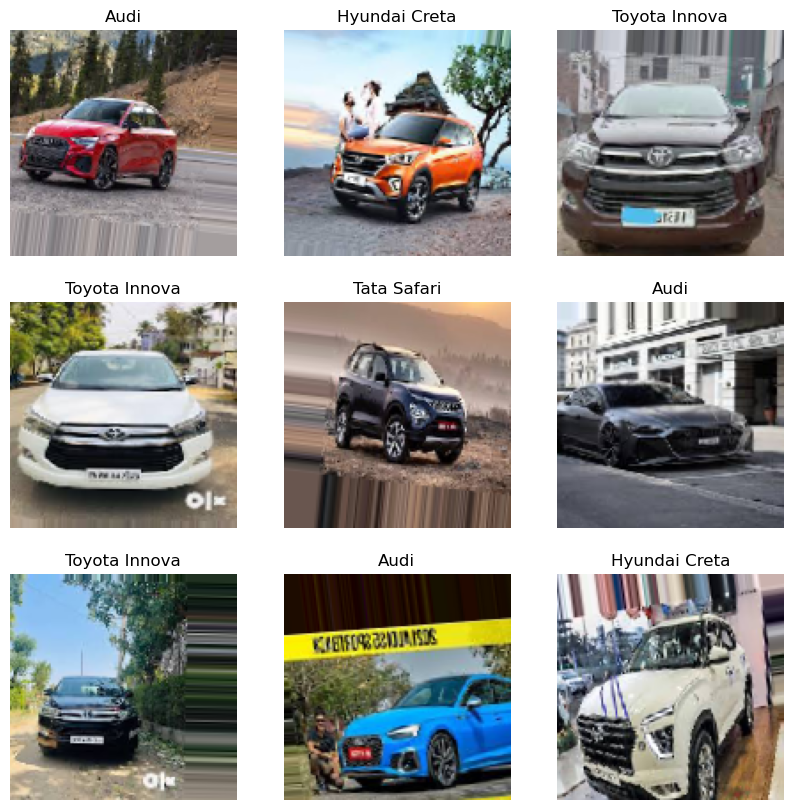

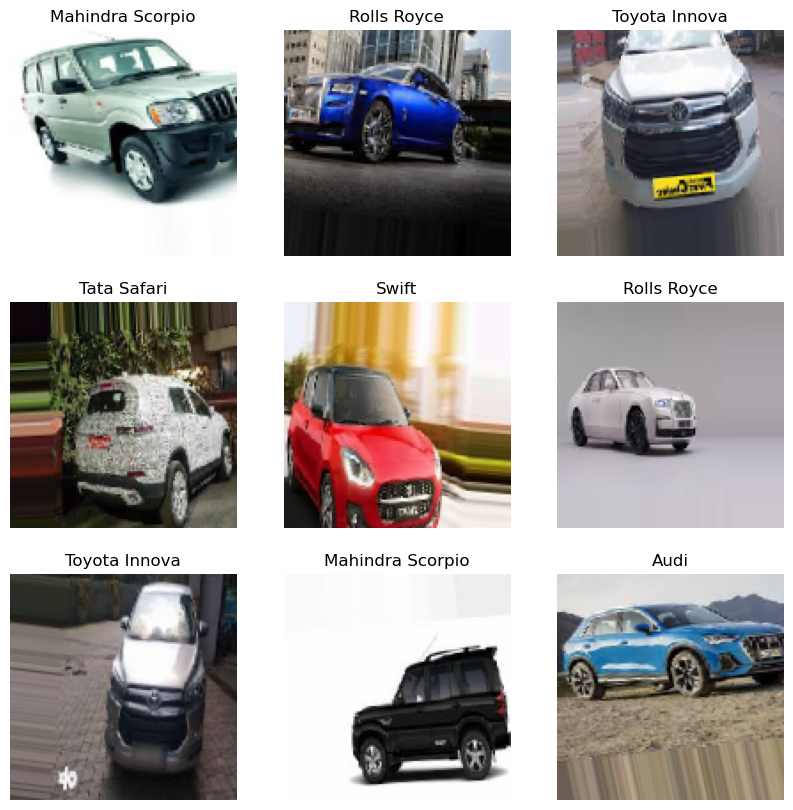

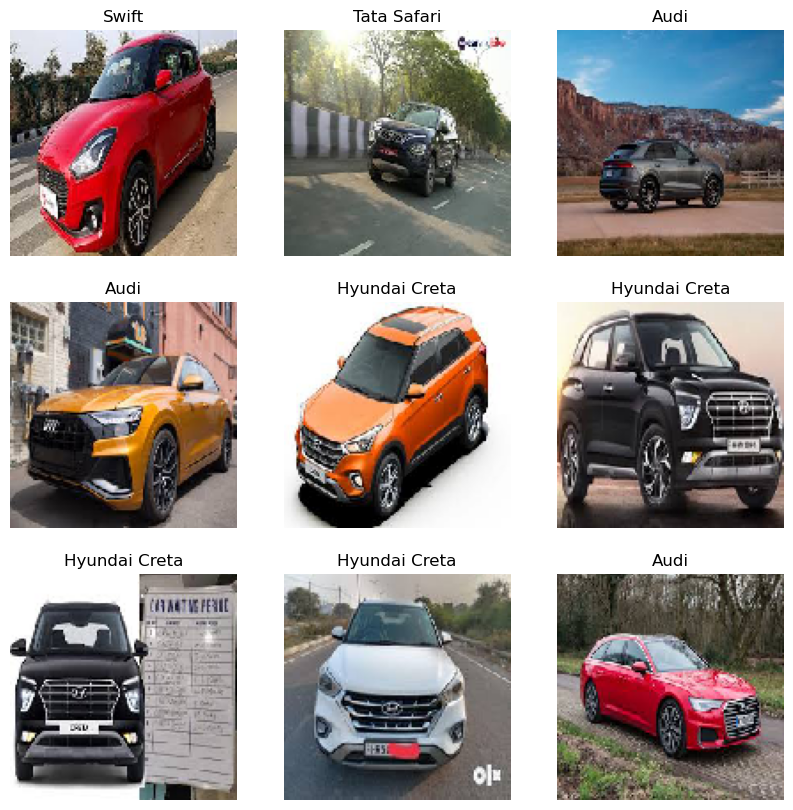

In [3]:
import matplotlib.pyplot as plt

# 클래스 레이블
class_labels = list(train_generator.class_indices.keys())

# 훈련용 데이터셋(train)에서 일부 이미지 및 레이블 확인
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])  # 클래스 레이블
        plt.axis('off')
    break  # 하나의 배치만 보여주기 위해 break
plt.show()

# 검증용 데이터셋(validation)에서 일부 이미지 및 레이블 확인
plt.figure(figsize=(10, 10))
for images, labels in validation_generator:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])  # 클래스 레이블
        plt.axis('off')
    break  # 하나의 배치만 보여주기 위해 break
plt.show()

# 테스트용 데이터셋(test)에서 일부 이미지 및 레이블 확인
plt.figure(figsize=(10, 10))
for images, labels in test_generator:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[np.argmax(labels[i])])  # 클래스 레이블
        plt.axis('off')
    break  # 하나의 배치만 보여주기 위해 break
plt.show()

In [4]:
def count_files(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# 훈련용 데이터셋(train) 이미지 개수 확인
train_image_count = count_files(train_dir)
print("훈련용 데이터셋(train) 이미지 개수:", train_image_count)


# 테스트용 데이터셋(test) 이미지 개수 확인
test_image_count = count_files(test_dir)
print("테스트용 데이터셋(test) 이미지 개수:", test_image_count)

훈련용 데이터셋(train) 이미지 개수: 3352
테스트용 데이터셋(test) 이미지 개수: 813


In [9]:
# CNN 모델 구성
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(units=512, activation='relu'),
    Dropout(0.4), 
    Dense(units=256, activation='relu'),
    Dropout(0.4), 
    Dense(len(train_generator.class_indices), activation='softmax')
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 요약 출력
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

In [10]:
# 모델 훈련
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/50
83/83 [==============================] - 17s 188ms/step - loss: 3.1401 - accuracy: 0.2187 - val_loss: 2.1751 - val_accuracy: 0.2453
Epoch 2/50
83/83 [==============================] - 15s 184ms/step - loss: 2.0254 - accuracy: 0.2481 - val_loss: 2.1313 - val_accuracy: 0.2359
Epoch 3/50
83/83 [==============================] - 15s 183ms/step - loss: 1.8870 - accuracy: 0.2896 - val_loss: 1.7862 - val_accuracy: 0.2891
Epoch 4/50
83/83 [==============================] - 15s 182ms/step - loss: 1.8240 - accuracy: 0.3126 - val_loss: 1.9347 - val_accuracy: 0.2500
Epoch 5/50
83/83 [==============================] - 15s 182ms/step - loss: 1.7563 - accuracy: 0.3526 - val_loss: 1.7110 - val_accuracy: 0.3578
Epoch 6/50
83/83 [==============================] - 15s 183ms/step - loss: 1.7317 - accuracy: 0.3695 - val_loss: 1.7742 - val_accuracy: 0.3422
Epoch 7/50
83/83 [==============================] - 15s 183ms/step - loss: 1.6904 - accuracy: 0.3797 - val_loss: 2.0162 - val_accuracy: 0.3156

In [11]:
scores = model.evaluate(test_generator)

scores

26/26 [==============================] - 1s 42ms/step - loss: 0.6721 - accuracy: 0.7700


[0.6720792651176453, 0.7699877023696899]

1/1 [==============================] - 0s 15ms/step
Number of the true predictions :  5 of 6


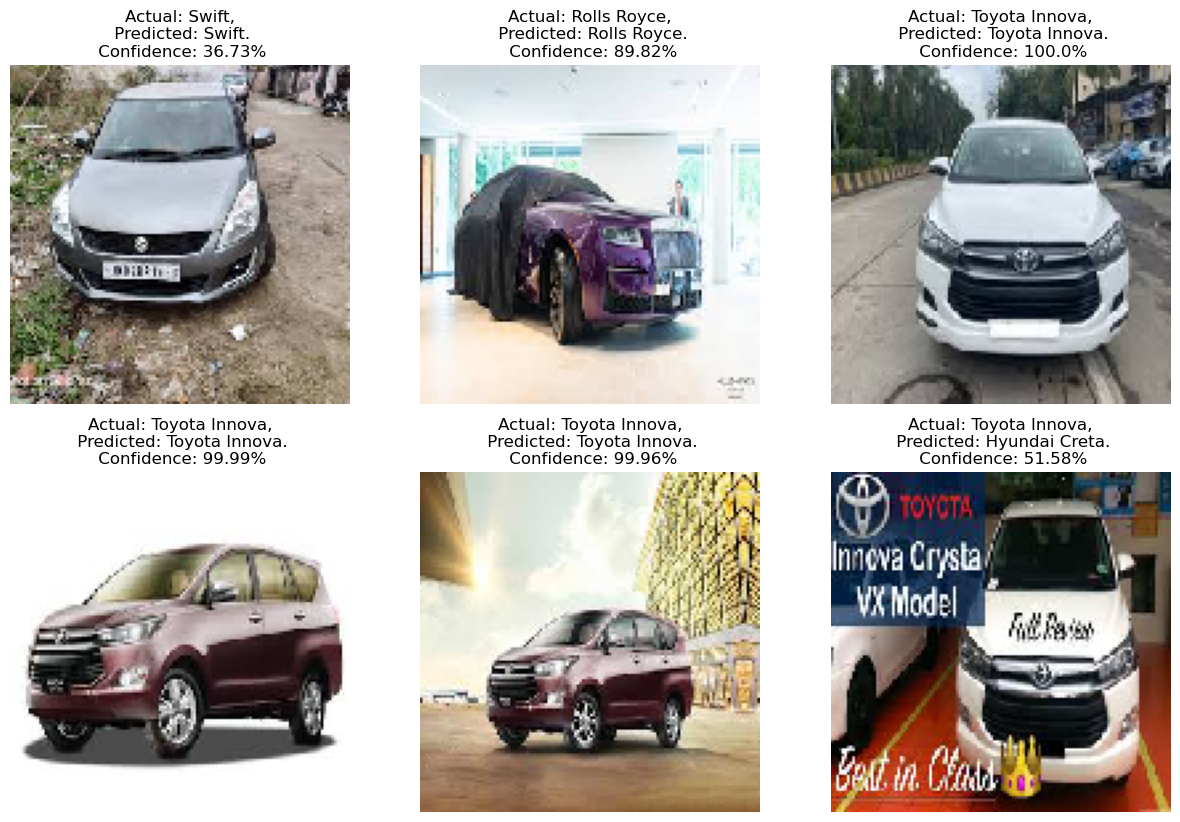

In [34]:
def predict_and_visualize(model, test_generator, num_images=6):
    class_names = list(test_generator.class_indices.keys())  # 클래스 이름을 가져오기
    plt.figure(figsize=(15, 15))  # 플롯 크기 설정
    cnt_y_1 = 0  # 정확하게 예측한 이미지의 수를 세기 위한 변수 초기화

    for images, labels in test_generator:  # 테스트 데이터셋에서 이미지와 레이블을 배치 단위로 가져옴
        # print(labels)
        for i in range(num_images):  # num_images 개수만큼의 이미지를 반복
            ax = plt.subplot(3, 3, i + 1)  # 3x3 격자의 서브플롯 생성
            plt.imshow(images[i])  # 각 서브플롯에 이미지 표시

            img_array = tf.expand_dims(images[i], 0)  # 이미지 배열에 차원 추가
            predictions = model.predict(img_array)  # 모델을 사용하여 예측 수행
            predicted_class = class_names[np.argmax(predictions[0])]  # 예측된 클래스
            confidence = round(100 * (np.max(predictions[0])), 2)  # 최대 확률을 백분율로 변환하여 신뢰도 계산

            actual_class = class_names[np.argmax(labels[i])]  # 실제 클래스 가져오기
            if predicted_class == actual_class:  # 예측이 정확한 경우
                cnt_y_1 += 1  # 정확한 예측 개수 증가
            
            # 타이틀 설정 (예측 클래스, 신뢰도 포함)
            plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            plt.axis("off")  # 축 제거

        break  # 한 배치만 처리하고 반복문 중단

    print("Number of the true predictions : ", cnt_y_1, "of", num_images)  # 정확하게 예측한 이미지의 수 출력

# 예측 및 시각화 수행
predict_and_visualize(model, test_generator)